In [5]:
from preprocessing import parse_data, vectorize_texts, LABELS
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import pandas as pd
import numpy as np
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from tqdm import tqdm_notebook
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
import itertools
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


# Лабораторная работа №2

Куклин Максим, 17ПМИ

Будем классифицировать новостные тексты, всего 4 категории - экономика, культуры, общество, политика.

Во время препроцессинга убираю пунктуационные знаки, привожу к нижнему регистру, убираю стоп слова, лемматизирую и
другая дополнительная минорная обработка. Текст векторизуется с помощью TF-IDF.

In [6]:
def get_metrics(model, test_data, test_label):
    y_pred = model.predict(test_data)
    acc = metrics.accuracy_score(test_label, y_pred)
    f1 = metrics.f1_score(test_label, y_pred, average='weighted')
    precision = metrics.precision_score(test_label, y_pred, average='weighted')
    recall = metrics.recall_score(test_label, y_pred, average='weighted')

    results = {
        "acc": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall,
    }

    return results, y_pred


def add_result(table, results):
    table = table.append(results, ignore_index=True)
    return table


def create_table(meta):
    table = pd.DataFrame()
    new_index = {}
    for i, (key, data) in enumerate(meta.items()):
        new_index[i] = key
        metrics = data['metrics']
        table = add_result(table, metrics)
    table = table.rename(index=new_index)
    return table

def _plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Oranges):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(LABELS.keys()))
    plt.xticks(tick_marks, rotation=45)
    ax = plt.gca()
    ax.set_xticklabels((ax.get_xticks()).astype(str))
    plt.yticks(tick_marks)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_confusion_matrix(y_test, y_pred, label='Confusion matrix'):
    cm = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    fig, ax = plt.subplots()
    _plot_confusion_matrix(cm, title=label)
    plt.plot()

In [7]:
texts, labels = parse_data()

X_train, X_test, y_train, y_test = train_test_split(
   texts, labels, test_size=0.25, random_state=1000)

tfIdfVectorizer = TfidfVectorizer()

X_train = tfIdfVectorizer.fit_transform(X_train)
X_test = tfIdfVectorizer.transform(X_test)

100%|██████████| 3626/3626 [01:08<00:00, 53.24it/s] 


In [27]:
classifier_list = [
    MultinomialNB(),
    LogisticRegression(),
    KNeighborsClassifier(n_neighbors=3),
    DecisionTreeClassifier(),
    svm.SVC(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier()
                    ]

In [33]:
meta = {}

for classifier in tqdm_notebook(classifier_list):
    classifier.fit(X_train, y_train)

    name = str(classifier).split('(')[0]

    meta[name] = {}
    meta[name]['classifier'] = classifier
    meta[name]['metrics'], meta[name]['prediction'] = \
        get_metrics(classifier, X_test, y_test)


<ipython-input-33-404bc20035a1>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for classifier in tqdm_notebook(classifier_list):


  0%|          | 0/8 [00:00<?, ?it/s]

In [34]:
table = create_table(meta)
table

,acc,f1,precision,recall
MultinomialNB,0.852064,0.847877,0.862301,0.852064
LogisticRegression,0.895642,0.894990,0.896735,0.895642
KNeighborsClassifier,0.848624,0.847393,0.847702,0.848624
DecisionTreeClassifier,0.750000,0.750724,0.752210,0.750000
SVC,0.899083,0.898949,0.901988,0.899083
RandomForestClassifier,0.850917,0.848431,0.852349,0.850917
AdaBoostClassifier,0.739679,0.742047,0.772550,0.739679
GradientBoostingClassifier,0.850917,0.851471,0.853562,0.850917


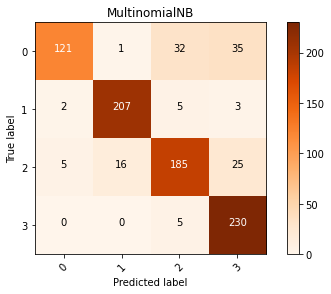

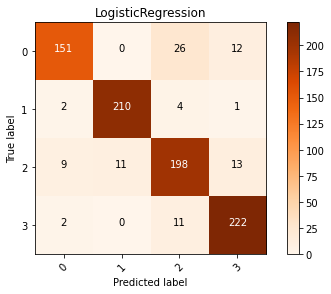

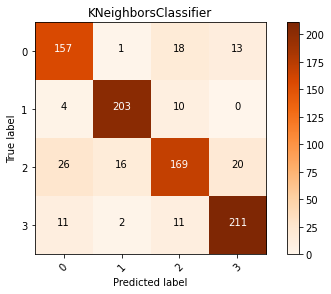

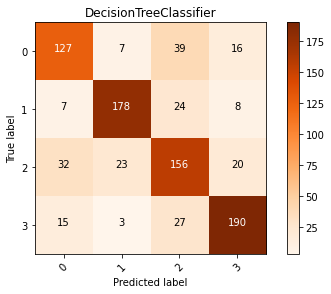

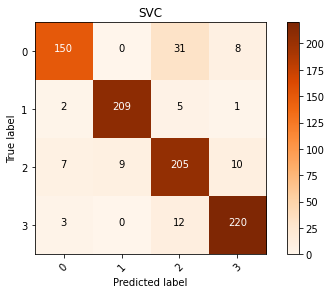

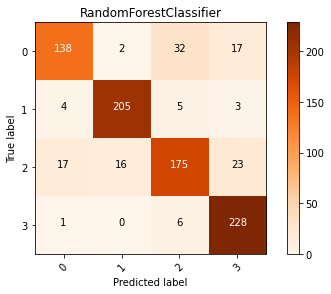

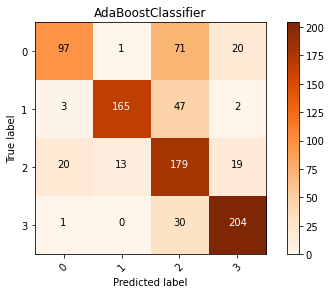

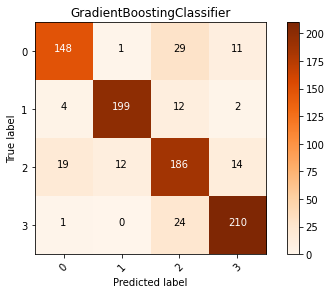

In [31]:
for cls in meta.keys():
    plot_confusion_matrix(y_test, meta[cls]['prediction'], str(meta[cls]['classifier']).split('(')[0])



Лучшим из классификаторов оказался SVM с точностью 0.899. Чаще всего классификаторы путают экономика и общество.
В целом, такая ситуация была предсказeума, так как тексты этих классов могут иметь похожие ключевые слова. Класс,
который имеет лучшую точность - политика.